In [7]:
import pandas as pd
import numpy as np
import math
import tools
from datetime import date
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as opt
from statsmodels.tsa.stattools import adfuller

In [3]:
# import plt.style.use('dark_background')
pd.options.display.max_rows = 20

**Explanation** 
<br>
This is a modification of the trading strategy on Main, meant to be more slick and application-friendly, with a number of differences. </p>
There's no auxiliary parts, such as band's confidence intervals computation via a statistical bootstrap </p>
The tradable asset is not a ratio of two tradable products, which is not tradable in a straight-forward/amateur manner. Instead, the tradable asset becomes a spread/linear combination of two tradable assets: $ \alpha \cdot Asset_{1} + \beta \cdot Asset_{2} $ </p>
The coefficients $ \alpha $ and $ \beta $ are determined (externally for now, on Rstudio) such that, on the train set, stationary metrics are maximized, so that it is somewhat sound to model the obtained linear combination as a OU model. </p>
There's no outlier removal. </p>
The transaction costs are not estimated, and fixed at $ 1 \% $

**Import and dataframe setup**

In [4]:
EURJPY1H_df = pd.read_excel('EURJPY1H.xls')
EURJPY1H=np.array(EURJPY1H_df)
USDJPY1H_df = pd.read_excel('USDJPY1H.xls')
USDJPY1H=np.array(USDJPY1H_df)
AUDUSD_df = pd.read_excel('AUDUSD.xls')
AUDUSD=np.array(AUDUSD_df)
NZDUSD_df = pd.read_excel('NZDUSD.xls')
NZDUSD=np.array(NZDUSD_df)

**Data preparation e run della strategy**

In [5]:
datas=pd.DataFrame(np.log((EURJPY1H-1.11*USDJPY1H)),columns=['logratio']); #not a logratio, it's a logspread
IS_datas=datas[:400]; 
OS_datas=datas[401:];
dt=1/(365*24);
(k,eta,sigma)=tools.MLE_estimator(IS_datas,dt);
(dummy1,eta_OS,dummy2)=tools.MLE_estimator(OS_datas,dt);
SIGMA=sigma/np.sqrt(2*k);
theta=1/k;
leverage=-1;
c=0.01*SIGMA; #arbitrarily fixed
loss=-1.96;
(band,new_lev)=tools.long_run(loss,c,theta,SIGMA,leverage,c/SIGMA);
L=loss*SIGMA;
D=band[1]*SIGMA;
U=band[0]*SIGMA;
ttm=28/365;
W0=1;
(mu_OS,Wt,check_in,check_out)=tools.tradingStrategy(U,D,L,new_lev,W0,ttm,OS_datas,c,eta);

Optimization terminated successfully.
         Current function value: -38.125129
         Iterations: 69
         Function evaluations: 128


logratio    2.083318
dtype: float64

**Plot preparation**

In [6]:
#Open positions and close position
openi = [lis[0] for lis in check_in] 
openp = [lis[1] for lis in check_in] 
closei = [lis[0] for lis in check_out] 
closep = [lis[1] for lis in check_out] 
#Trading band
t = np.arange(0,OS_datas.shape[0],10)
Ll = np.full(len(t),loss*SIGMA+eta)
Ls = np.full(len(t),-loss*SIGMA+eta)
Dl = np.full(len(t),band[1]*SIGMA+eta)
Ds = np.full(len(t),-band[1]*SIGMA+eta)
Ul = np.full(len(t),band[0]*SIGMA+eta)
Us = np.full(len(t),-band[0]*SIGMA+eta)
OS_datas = OS_datas.reset_index()

**Plot**    
Plot of the trading strategy on the OS sample. Both the openings and closing of different positions (long/short) and trading bands (long/short) are shown.

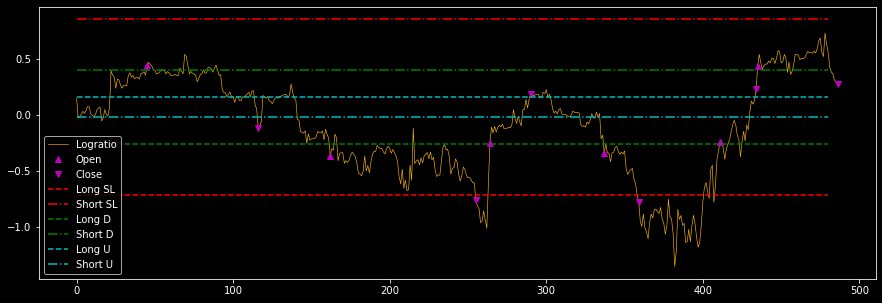

In [59]:
fig, ax = plt.subplots(figsize=(15,5))
plt.style.use('dark_background')
plt.plot(OS_datas['logratio'],color = (1, 0.73, 0.06), linewidth=0.6)
plt.plot(openi,openp,'m^',closei,closep,'mv',t,Ll,'r--',t,Ls,'r-.',t,Dl,'g--',t,Ds,'g-.',t,Ul,'c--',t,Us,'c-.')
plt.legend(['Logratio','Open','Close','Long SL','Short SL','Long D','Short D','Long U','Short U'])
fig.canvas.draw()


Application of the trading strategy over the OS data